## <span style="color:#FA8072"> 1. Import Libraries </span> <a class="anchor" id="import_libraries"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,confusion_matrix

In [ ]:
import boto3
import gzip
from io import BytesIO

# Replace these with your S3 bucket and folder path containing zip files
bucket_name = 'credit-classification-transformed'
folder_path = 'train-dataset/'

# Create an S3 client
s3 = boto3.client('s3')

# List objects in the S3 bucket and filter for zip files in the specified folder
response = s3.list_objects(Bucket=bucket_name, Prefix=folder_path)
# print(response)
gzip_files = [obj['Key'] for obj in response.get('Contents', []) if obj['Key'].endswith('.gz')]

# Create an empty Pandas DataFrame
df_train_original = pd.DataFrame()

# Loop through each gzip file and extract content
for gzip_file in gzip_files:
    # Download the gzip file from S3
    response = s3.get_object(Bucket=bucket_name, Key=gzip_file)
    gzip_content = response['Body'].read()

    # Decompress the content
    with gzip.open(BytesIO(gzip_content), 'rt', encoding='utf-8') as f:
        # Read the CSV data using Pandas
        # Assume that the file is comma-separated (CSV)
        csv_data = pd.read_csv(f)

    # Append the CSV data to the DataFrame
    df_train_original = df_train_original.append(csv_data, ignore_index=True)


## <span style="color:#FA8072"> 3. Load Data </span> <a class="anchor" id="load_data"></a>

In [3]:
df_train_original = pd.read_csv('train.csv')
df_train = df_train_original.copy()
df_train.head()

C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\4136590211.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_original = pd.read_csv('train.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## <span style="color:#FA8072"> 4.  Exploratory Data Analysis </span> <a class="anchor" id="eda"></a>

## <span style="color:#FA8072"> 4.1  Preview Dataset </span> <a class="anchor" id="preview_dataset"></a>

In [4]:
df_train.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [5]:
#Check Data Size
print('Train Data Size : ',df_train.shape)

Train Data Size :  (100000, 28)


In [6]:
df_train.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [7]:
#Check Train dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

<h4> Observations : </h4>
    
1. There are missing values present in dataset.
2. Train dataset has both numerical and string values. 

In [8]:
#Check statistical values for fields with numerical datatype
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,84998.0,4194.170850,3183.686167,303.645417,1625.568229,3093.745000,5957.448333,15204.633333
Num_Bank_Accounts,100000.0,17.091280,117.404834,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,100000.0,22.474430,129.057410,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,100000.0,72.466040,466.422621,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,100000.0,21.068780,14.860104,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,98035.0,27.754251,193.177339,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,100000.0,32.285173,5.116875,20.000000,28.052567,32.305784,36.496663,50.000000
Total_EMI_per_month,100000.0,1403.118217,8306.041270,0.000000,30.306660,69.249473,161.224249,82331.000000


In [9]:
#Check statistical values for fields with other than numerical datatype
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,100000,100000,0x1602,1
Customer_ID,100000,12500,CUS_0xd40,8
Month,100000,8,January,12500
Name,90015,10139,Langep,44
Age,100000,1788,38,2833
SSN,100000,12501,#F%$D@*&8,5572
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,36585.12,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408


**Observations**
1. Customer_ID has 12500 unique values. It means we have data of 12500 customers.
2. Month has only 8 unique values. Better to analyse further which months are present. 
3. Age has 1788 unique values. This looks strange as general age range is from 0-100. 
4. SSN has 12501 unique values, whereas Customer_ID only has only 12500 unique values. There is a possibility that incorrect SSN value is entered for one of the customer as same person can't have multiple SSN. 

## <span style="color:#FA8072"> 4.2 Helper Functions </span> <a class="anchor" id="helper_functions"></a>
Created following functions that will help in exploring,analysing & cleaning of the data

In [10]:
def get_column_details(df,column):
    print("Details of",column,"column")
    
    #DataType of column
    print("\nDataType: ",df[column].dtype)
    
    #Check if null values are present
    count_null = df[column].isnull().sum()
    if count_null==0:
        print("\nThere are no null values")
    elif count_null>0:
        print("\nThere are ",count_null," null values")
        
    #Get Number of Unique Values
    print("\nNumber of Unique Values: ",df[column].nunique())
    
    #Get Distribution of Column    
    print("\nDistribution of column:\n")
    print(df[column].value_counts())

In [11]:
def fill_missing_with_group_mode(df, groupby, column):      
    print("\nNo. of missing values before filling with group mode:",df[column].isnull().sum())
    
    # Fill with local mode
    mode_per_group = df.groupby(groupby)[column].transform(lambda x: x.mode().iat[0])
    df[column] = df[column].fillna(mode_per_group)
    
    print("\nNo. of missing values after filling with group mode:",df[column].isnull().sum())

In [12]:
#Method to clean categorical field

def clean_categorical_field(df,groupby,column,replace_value=None):
    print("\n-----------------------------------------------------")
    print("\nCleaning steps ")
    
    #Replace with np.nan
    if replace_value!=None:
        df[column] = df[column].replace(replace_value,np.nan)
        print(f"\nGarbage value {replace_value} is replaced with np.nan")

    #For each Customer_ID, assign same value for the column
    fill_missing_with_group_mode(df,groupby,column)

In [13]:
# Handle Outliers and null values
def fix_inconsistent_values(df, groupby, column):      
    print("\nExisting Min, Max Values:", df[column].apply([min, max]), sep='\n', end='\n')   
    
    df_dropped = df[df[column].notna()].groupby(groupby)[column].apply(list)
    x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])
    mini, maxi = x[0][0], y[0][0]

    # assign Wrong Values to NaN
    col = df[column].apply(lambda x: np.NaN if ((x<mini)|(x>maxi)|(x<0)) else x)

    # fill with local mode
    mode_by_group = df.groupby(groupby)[column].transform(lambda x: x.mode()[0] if not x.mode().empty else np.NaN)
    df[column] = col.fillna(mode_by_group)
    df[column].fillna(df[column].mean(),inplace=True)

    print("\nAfter Cleaning Min, Max Values:", df[column].apply([min, max]), sep='\n', end='\n') 
    print("\nNo. of Unique values after Cleaning:",df[column].nunique())
    print("\nNo. of Null values after Cleaning:",df[column].isnull().sum())

In [14]:
#Method to clean Numerical Field
def clean_numerical_field(df,groupby,column,strip=None,datatype=None,replace_value=None):
    print("\n-----------------------------------------------------")
    print("\nCleaning steps ")
    
    #Replace with np.nan
    if replace_value!=None:
        df[column] = df[column].replace(replace_value,np.nan)
        print(f"\nGarbage value {replace_value} is replaced with np.nan")
        
    # Remove trailing & leading special characters
    if df[column].dtype == object and strip is not None:
        df[column] = df[column].str.strip(strip)
        print(f"\nTrailing & leading {strip} are removed")

    # Change datatype
    if datatype is not None:
        df[column] = df[column].astype(datatype)
        print(f"\nDatatype of {column} is changed to {datatype}")

    fix_inconsistent_values(df, groupby, column)

In [15]:
def plot_countplot(df,column,user_friendly_column_name,rotation=0):
    print("\n-----------------------------------------------------")
    print(f'\n{user_friendly_column_name} Distribution')
    palette = "deep" 
    sns.set_palette(palette)
    
    sns.countplot(data=df, x=column)

    plt.xlabel(f'{user_friendly_column_name}')
    plt.ylabel('Number of Records')
    plt.title(f'{user_friendly_column_name} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

In [16]:
def plot_displot(df,column,user_friendly_column_name,rotation=0,bins=20):
    print("\n-----------------------------------------------------")
    print(f'\n{user_friendly_column_name} Distribution')
    palette = "deep" 
    sns.set_palette(palette)
    
    sns.displot(data=df, x=column, kde=True, bins=bins)

    plt.xlabel(f'{user_friendly_column_name}')
    plt.ylabel('Number of Records')
    plt.title(f'{user_friendly_column_name} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

In [17]:
def plot_stacked_bar(df,column1,column2,rotation=0):
    print("\n-----------------------------------------------------")
    print(f'\n{column1} & {column2} Distribution')
    palette = "deep" 
    sns.set_palette(palette)

    pd.crosstab(df[column1], df[column2]).plot(kind='bar', stacked=True)
    
    plt.xlabel(f'{column1}')
    plt.ylabel('Number of Records')
    plt.title(f'{column1} & {column2} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

## <span style="color:#FA8072"> 4.3 Categorical Variables </span> <a class="anchor" id="categorical_variables"></a>

### Credit Score 

**Summary**

1. There are 3 different Credit Score - Standard, Good & Poor.
2. Distribution of credit score - 

   a) Standard - 53%
   
   b) Poor - 29%
   
   c) Good - 17%
   
3. There are no null values for Credit Score.

Details of Credit_Score column

DataType:  object

There are no null values

Number of Unique Values:  3

Distribution of column:

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

-----------------------------------------------------

Credit Score Distribution


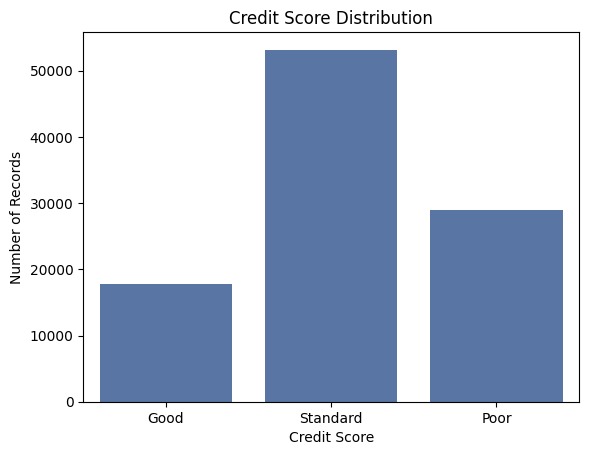

In [18]:
column_name = 'Credit_Score'
user_friendly_name = 'Credit Score'

#Get Details
get_column_details(df_train,column_name)

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name)

### <span> ID </span> <a class="anchor" id="id"></a>

**Summary**

1. There are 100000 distinct records and no null values present.

In [19]:
#Get Details
get_column_details(df_train,'ID')

Details of ID column

DataType:  object

There are no null values

Number of Unique Values:  100000

Distribution of column:

ID
0x1602     1
0x19c88    1
0x19caa    1
0x19ca5    1
0x19ca4    1
          ..
0xd94d     1
0xd94c     1
0xd94b     1
0xd94a     1
0x25fed    1
Name: count, Length: 100000, dtype: int64


### Customer ID 

**Summary**

1. We have record of 12500 unique customers. 
2. Same customer can have different credit score. It means that on the basis of other values customer credit score can change. 

In [20]:
#Get Details 
get_column_details(df_train,'Customer_ID')

Details of Customer_ID column

DataType:  object

There are no null values

Number of Unique Values:  12500

Distribution of column:

Customer_ID
CUS_0xd40     8
CUS_0x9bf4    8
CUS_0x5ae3    8
CUS_0xbe9a    8
CUS_0x4874    8
             ..
CUS_0x2eb4    8
CUS_0x7863    8
CUS_0x9d89    8
CUS_0xc045    8
CUS_0x942c    8
Name: count, Length: 12500, dtype: int64


In [21]:
#Check if same customer can have different credit score
df_train.groupby(['Customer_ID'])['Credit_Score'].nunique()

Customer_ID
CUS_0x1000    2
CUS_0x1009    1
CUS_0x100b    2
CUS_0x1011    1
CUS_0x1013    1
             ..
CUS_0xff3     2
CUS_0xff4     1
CUS_0xff6     2
CUS_0xffc     2
CUS_0xffd     2
Name: Credit_Score, Length: 12500, dtype: int64

### Month 

**Summary**

1. In the training dataset, we have credit score for each customer over the course of 8 months(from January to August).
2. Converted Month column from object to datetime value so that it can be further use for model building. 
3. Distribution of Credit_Scrore across different months is similar.

Details of Month column

DataType:  object

There are no null values

Number of Unique Values:  8

Distribution of column:

Month
January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: count, dtype: int64

-----------------------------------------------------

Month & Credit_Score Distribution


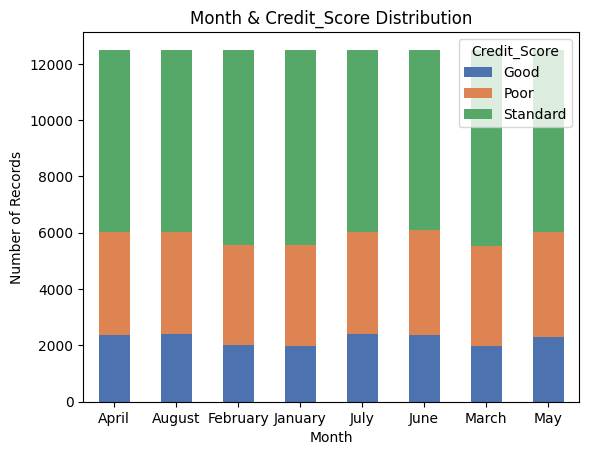

In [22]:
column_name = 'Month'

#Get Details
get_column_details(df_train,column_name)

#Plot Distrbution with Credit_Score
plot_stacked_bar(df_train,column_name,'Credit_Score')

In [23]:
#Convert Month to datetime object
df_train['Month'] = pd.to_datetime(df_train.Month, format='%B').dt.month

### Name 

**Summary**

1. There are 9985 null values. 
2. Cleaning Step - Assign same Name value to each Customer_ID

In [24]:
column_name = 'Name'
group_by = 'Customer_ID'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_categorical_field(df_train,group_by,column_name)

Details of Name column

DataType:  object

There are  9985  null values

Number of Unique Values:  10139

Distribution of column:

Name
Langep            44
Stevex            44
Vaughanl          39
Jessicad          39
Raymondr          38
                  ..
Alina Selyukhg     4
Habboushg          4
Mortimerq          4
Ronaldf            4
Timothyl           3
Name: count, Length: 10139, dtype: int64

-----------------------------------------------------

Cleaning steps 

No. of missing values before filling with group mode: 9985

No. of missing values after filling with group mode: 0


### SSN 

**Summary**

1. There are 12501 unique SSN values in training dataset. 
2. 5572 entries has random/garbage value as SSN value
3. Steps to Clean SSN -

    i. Replace garbage value with np.nan
    
    ii. Assign same SSN value for each customer ID

In [25]:
column_name = 'SSN'
group_by = 'Customer_ID'
garbage_value = '#F%$D@*&8'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_categorical_field(df_train,group_by,column_name,garbage_value)

Details of SSN column

DataType:  object

There are no null values

Number of Unique Values:  12501

Distribution of column:

SSN
#F%$D@*&8      5572
078-73-5990       8
486-78-3816       8
750-67-7525       8
903-50-0305       8
               ... 
856-06-6147       4
753-72-2651       4
331-28-1921       4
604-62-6133       4
286-44-9634       4
Name: count, Length: 12501, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value #F%$D@*&8 is replaced with np.nan

No. of missing values before filling with group mode: 5572

No. of missing values after filling with group mode: 0


### Occupation 

**Summary**

1. There are 16 unique Occupation values. 
2. 7062 records are marked with garbage value.
3. Steps to Clean Occupation -

    i. Replace garbage value with np.nan
    
    ii. Assign same Occupation value for each customer ID
4. Distribution of Credit_Scrore across different occupation is similar.

Details of Occupation column

DataType:  object

There are no null values

Number of Unique Values:  16

Distribution of column:

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _______ is replaced with np.nan

No. of missing values before filling with group mode: 7062

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Occupation & Credit_Score Distribution


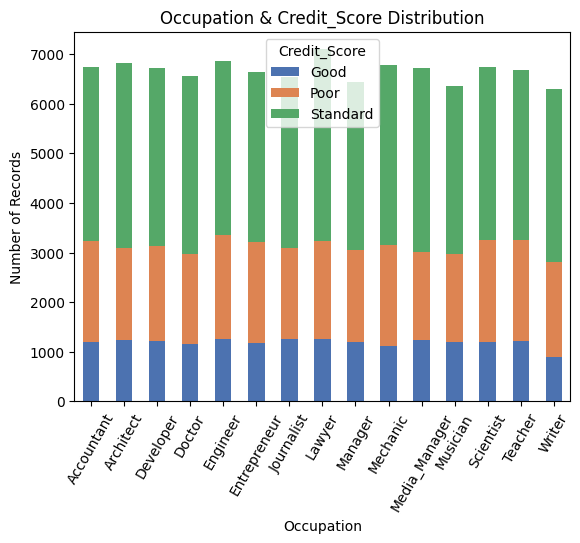

In [26]:
column_name = 'Occupation'
group_by = 'Customer_ID'
garbage_value = '_______'
user_friendly_name = 'Occupation'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_categorical_field(df_train,group_by,column_name,garbage_value)

#Plot Distribution with Credit_Score
plot_stacked_bar(df_train,column_name,'Credit_Score',rotation=60)

### Type of Loan

**Summary**

1. There are 6260 unique values present for Type of Loan and there are null values present.
2. Mapped all null values to *Not Specificed* for Type of Loan column.

In [27]:
#Get Details of Type of Loan column
get_column_details(df_train,'Type_of_Loan')

Details of Type_of_Loan column

DataType:  object

There are  11408  null values

Number of Unique Values:  6260

Distribution of column:

Type_of_Loan
Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified,

In [28]:
#Handle Type of Loan null values
df_train['Type_of_Loan'].replace([np.NaN], 'Not Specified', inplace=True)

### Credit Mix

**Summary**

1. There are 3 types of Credit Mix - Standard, Good, Bad
2. About 20k records of Credit Mix is marked as a garbage value (_).
3. Steps to Clean Credit Mix Field -

    i. Replace garbage value with np.nan
    
    ii. Assign same Credit Mix value for each customer ID

Details of Credit_Mix column

DataType:  object

There are no null values

Number of Unique Values:  4

Distribution of column:

Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _ is replaced with np.nan

No. of missing values before filling with group mode: 20195

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Credit_Mix & Credit_Score Distribution


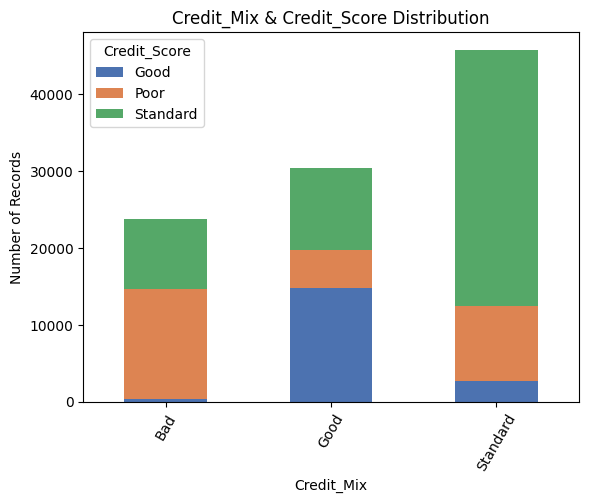

In [29]:
column_name = 'Credit_Mix'
group_by = 'Customer_ID'
garbage_value = '_'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_categorical_field(df_train,group_by,column_name,garbage_value)

#Plot Distribution with Credit_Score
plot_stacked_bar(df_train,column_name,'Credit_Score',rotation=60)

### Payment of Min Amount

**Summary**

1. There are 3 unique values present - Yes, No & NM.
2. No missing values are present.

Details of Payment_of_Min_Amount column

DataType:  object

There are no null values

Number of Unique Values:  3

Distribution of column:

Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

-----------------------------------------------------

Payment_of_Min_Amount & Credit_Score Distribution


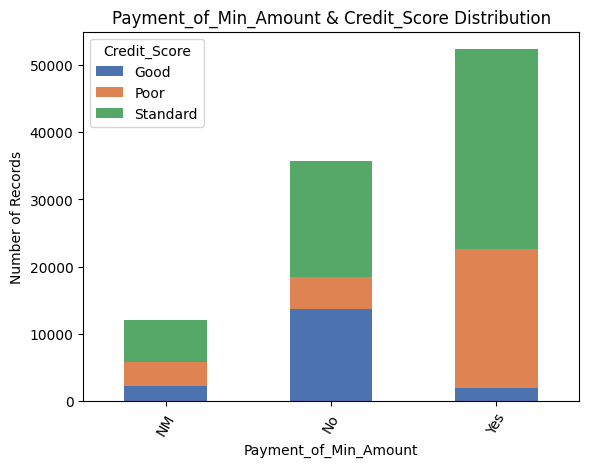

In [30]:
column_name = 'Payment_of_Min_Amount'

#Get Details
get_column_details(df_train,column_name)

#Plot Distribution with Credit_Score
plot_stacked_bar(df_train,column_name,'Credit_Score',rotation=60)

### Payment Behaviour

**Summary**

1. There are 6 unique values of Payment Behaviour -

    Low_spent_Small_value_payments      
    High_spent_Medium_value_payments    
    Low_spent_Medium_value_payments     
    High_spent_Large_value_payments     
    High_spent_Small_value_payments     
    Low_spent_Large_value_payments  
   
2. Amount 27% of records are for Low_spent_Small_value_payments
    
3. For 7.6k records, Payment Behaviour is filled with garbage value

4. Steps to Clean Payment Behaviour Field -

    i. Replace garbage value with np.nan
    
    ii. Assign same Payment Behaviour value for each customer ID
    

Details of Payment_Behaviour column

DataType:  object

There are no null values

Number of Unique Values:  7

Distribution of column:

Payment_Behaviour
Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: count, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value !@9#%8 is replaced with np.nan

No. of missing values before filling with group mode: 7600

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Payment_Behaviour & Credit_Score Distribution


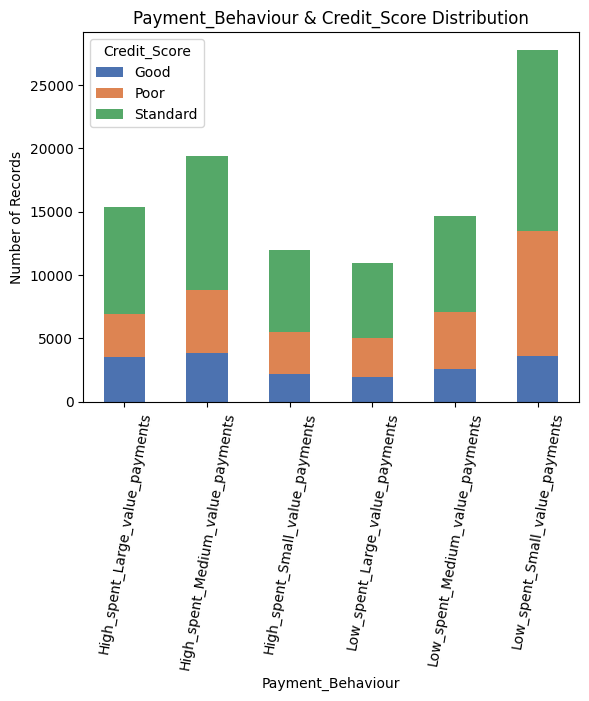

In [31]:
column_name = 'Payment_Behaviour'
group_by = 'Customer_ID'
garbage_value = '!@9#%8'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_categorical_field(df_train,group_by,column_name,garbage_value)

#Plot Distribution with Credit_Score
plot_stacked_bar(df_train,column_name,'Credit_Score',rotation=80)

## <span style="color:#FA8072"> 4.4 Numerical Variables </span> <a class="anchor" id="numerical_variables"></a>

**Cleaning Steps**
1. Remove Trailing & Leading speical characters.
2. Convert datatype from object to int/float if required.
3. Replace null values & outliers with mode value when group by Customer_ID

### Age

**Summary**

1. There are 1788 unique values of Age and it is stored as an object. Having 1788 distinct values of Age mean that there is a lot of dirty data.
2. After cleaning up Age value, 43 distinct Age remains. 
    

Details of Age column

DataType:  object

There are no null values

Number of Unique Values:  1788

Distribution of column:

Age
38      2833
28      2829
31      2806
26      2792
32      2749
        ... 
471        1
1520       1
8663       1
3363       1
1342       1
Name: count, Length: 1788, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Age is changed to int

Existing Min, Max Values:
min    -500
max    8698
Name: Age, dtype: int32


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    14.0
max    56.0
Name: Age, dtype: float64

No. of Unique values after Cleaning: 43

No. of Null values after Cleaning: 0

-----------------------------------------------------

Age Distribution


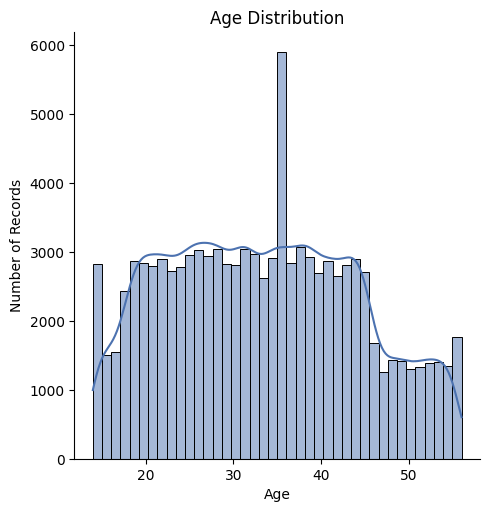

In [32]:
column_name = 'Age'
group_by = 'Customer_ID'
user_friendly_name = 'Age'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype='int')

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=40)

### Annual Income

**Summary**

1. Annual Income has no null values. 
2. Most customers have a low Annual income. Distribution is right skewed. 

Details of Annual_Income column

DataType:  object

There are no null values

Number of Unique Values:  18940

Distribution of column:

Annual_Income
36585.12     16
20867.67     16
17273.83     16
9141.63      15
33029.66     15
             ..
20269.93_     1
15157.25_     1
44955.64_     1
76650.12_     1
4262933.0     1
Name: count, Length: 18940, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Annual_Income is changed to float

Existing Min, Max Values:
min        7005.93
max    24198062.00
Name: Annual_Income, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min      7005.93
max    179987.28
Name: Annual_Income, dtype: float64

No. of Unique values after Cleaning: 12488

No. of Null values after Cleaning: 0

-----------------------------------------------------

Annual Income Distribution


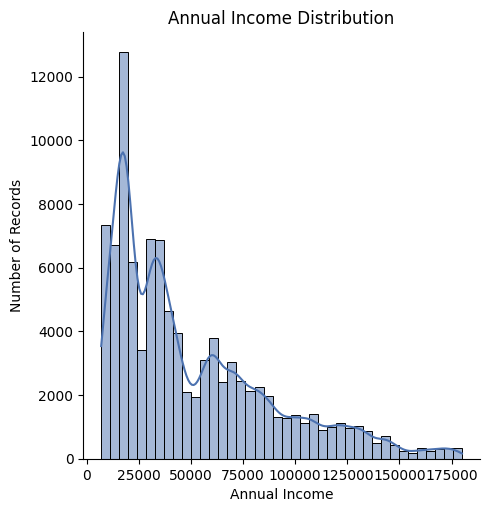

In [33]:
column_name = 'Annual_Income'
group_by = 'Customer_ID'
user_friendly_name = 'Annual Income'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype='float')

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=40)

### Monthly Inhand Salary

**Summary**

1. There are null values present.
2. No outliers were present for Monthly Income Salary.
3. Most customers have a low monthly income. Distribution is right skewed.

Details of Monthly_Inhand_Salary column

DataType:  float64

There are  15002  null values

Number of Unique Values:  13235

Distribution of column:

Monthly_Inhand_Salary
6769.130000    15
6358.956667    15
2295.058333    15
6082.187500    15
3080.555000    14
               ..
1087.546445     1
3189.212103     1
5640.117744     1
7727.560450     1
2443.654131     1
Name: count, Length: 13235, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min      303.645417
max    15204.633333
Name: Monthly_Inhand_Salary, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min      303.645417
max    15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

No. of Unique values after Cleaning: 13235

No. of Null values after Cleaning: 0

-----------------------------------------------------

Monthly Inhand Salary Distribution


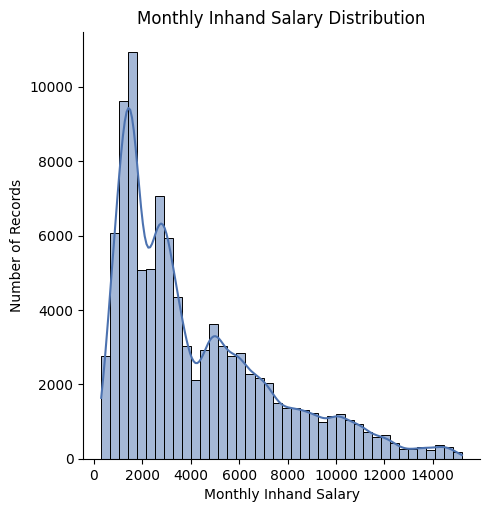

In [34]:
column_name = 'Monthly_Inhand_Salary'
group_by = 'Customer_ID'
user_friendly_name = 'Monthly Inhand Salary'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=40)

### Num Bank Accounts

**Summary**

1. There are some outliers,negative values in Num Bank Accounts
2. After cleaning, there are 11 possible value of this field - Num Bank Accounts ranging from 0 to 10.
3. Majority of customers has no. of bank accounts between 3 to 8.

Details of Num_Bank_Accounts column

DataType:  int64

There are no null values

Number of Unique Values:  943

Distribution of column:

Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1626        1
1470        1
887         1
211         1
697         1
Name: count, Length: 943, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min      -1
max    1798
Name: Num_Bank_Accounts, dtype: int64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    -1.0
max    10.0
Name: Num_Bank_Accounts, dtype: float64

No. of Unique values after Cleaning: 12

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Bank Accounts Distribution


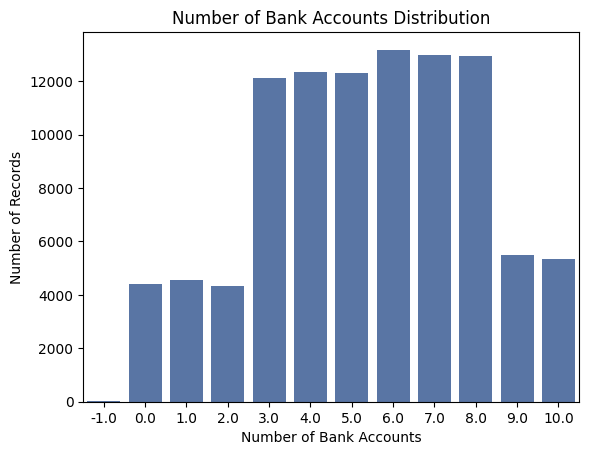

In [35]:
column_name = 'Num_Bank_Accounts'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Bank Accounts'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name)

### Num Credit Cards

**Summary**

1. There are outliers present in the field as there are 1179 unique values of number of credit card.
2. After removing outliers, number of credit cards range from 0 to 11 with most of the customers having credit cards in the range of 3 to 7 with peak at 5.


Details of Num_Credit_Card column

DataType:  int64

There are no null values

Number of Unique Values:  1179

Distribution of column:

Num_Credit_Card
5       18459
7       16615
6       16559
4       14030
3       13277
        ...  
791         1
1118        1
657         1
640         1
679         1
Name: count, Length: 1179, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       0
max    1499
Name: Num_Credit_Card, dtype: int64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min     0.0
max    11.0
Name: Num_Credit_Card, dtype: float64

No. of Unique values after Cleaning: 12

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Credit Card Distribution


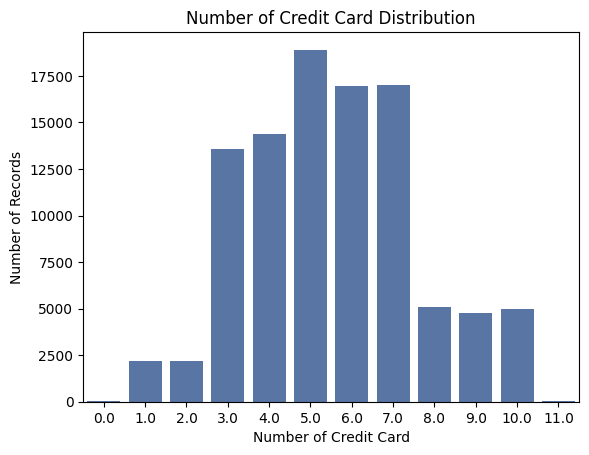

In [36]:
column_name = 'Num_Credit_Card'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Credit Card'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name)

### Interest Rate

**Summary**

1. There were outliers present, after cleaning them up, interest rate ranges from 1% to 34%

Details of Interest_Rate column

DataType:  int64

There are no null values

Number of Unique Values:  1750

Distribution of column:

Interest_Rate
8       5012
5       4979
6       4721
12      4540
10      4540
        ... 
4995       1
1899       1
2120       1
5762       1
5729       1
Name: count, Length: 1750, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       1
max    5797
Name: Interest_Rate, dtype: int64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min     1.0
max    34.0
Name: Interest_Rate, dtype: float64

No. of Unique values after Cleaning: 34

No. of Null values after Cleaning: 0

-----------------------------------------------------

Interest Rate Distribution


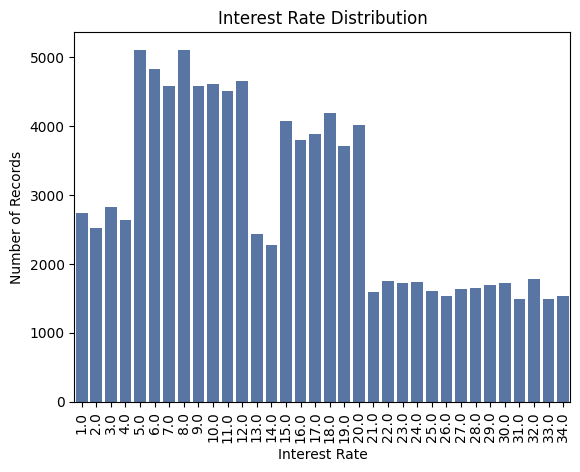

In [37]:
column_name = 'Interest_Rate'
group_by = 'Customer_ID'
user_friendly_name = 'Interest Rate'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name,rotation=90)

### Delay from Due Date

**Summary**

1. Delay from due date is concentrated between 0 to 30 days. 

Details of Delay_from_due_date column

DataType:  int64

There are no null values

Number of Unique Values:  73

Distribution of column:

Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min    -5
max    67
Name: Delay_from_due_date, dtype: int64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    -5.0
max    62.0
Name: Delay_from_due_date, dtype: float64

No. of Unique values after Cleaning: 68

No. of Null values after Cleaning: 0

-----------------------------------------------------

Delay from Due Date Distribution


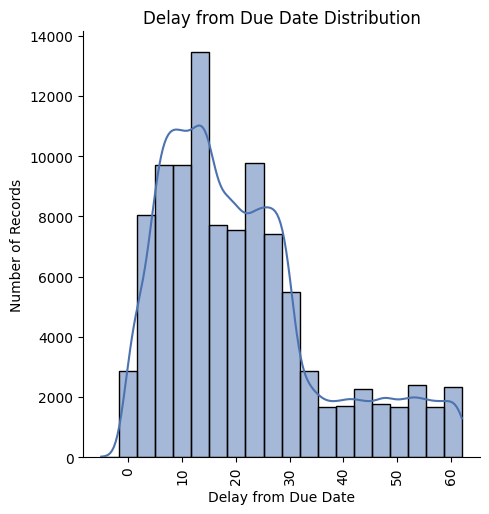

In [38]:
column_name = 'Delay_from_due_date'
group_by = 'Customer_ID'
user_friendly_name = 'Delay from Due Date'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,rotation=90)

### Number of Delayed Payment

**Summary**

Details of Num_of_Delayed_Payment column

DataType:  object

There are  7002  null values

Number of Unique Values:  749

Distribution of column:

Num_of_Delayed_Payment
19      5327
17      5261
16      5173
10      5153
18      5083
        ... 
848_       1
4134       1
1530       1
1502       1
2047       1
Name: count, Length: 749, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Num_of_Delayed_Payment is changed to float

Existing Min, Max Values:
min      -3.0
max    4397.0
Name: Num_of_Delayed_Payment, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    -2.0
max    28.0
Name: Num_of_Delayed_Payment, dtype: float64

No. of Unique values after Cleaning: 31

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Delayed Payment Distribution


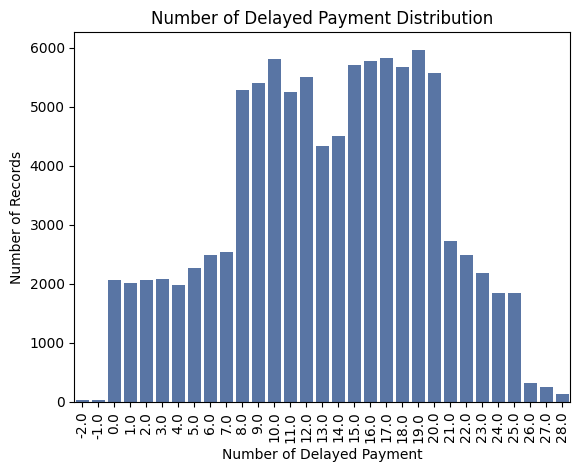

In [39]:
column_name = 'Num_of_Delayed_Payment'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Delayed Payment'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype='float')

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name,rotation=90)

### Changed Credit Limit

**Summary**

Details of Changed_Credit_Limit column

DataType:  object

There are no null values

Number of Unique Values:  4384

Distribution of column:

Changed_Credit_Limit
_                     2091
8.22                   133
11.5                   127
11.32                  126
7.35                   121
                      ... 
-1.84                    1
0.8899999999999999       1
28.06                    1
1.5599999999999996       1
21.17                    1
Name: count, Length: 4384, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Changed_Credit_Limit is changed to float

Existing Min, Max Values:
min    -6.49
max    36.97
Name: Changed_Credit_Limit, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    -5.01
max    29.98
Name: Changed_Credit_Limit, dtype: float64

No. of Unique values after Cleaning: 3532

No. of Null values after Cleaning: 0

-----------------------------------------------------

Changed Credit Limit Distribution


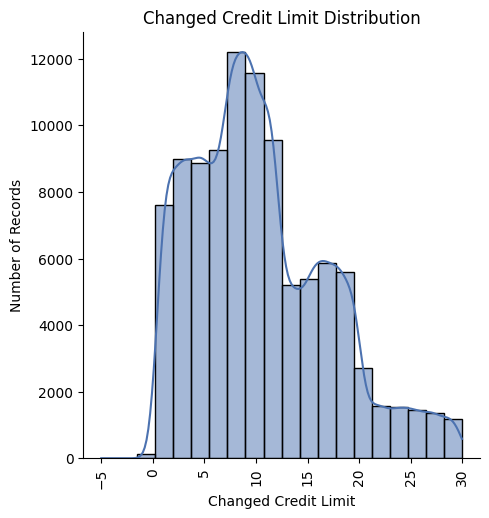

In [40]:
column_name = 'Changed_Credit_Limit'
group_by = 'Customer_ID'
user_friendly_name = 'Changed Credit Limit'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype='float',replace_value='_')

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,rotation=90)

### Number of Credit Inquiries

**Summary**

Details of Num_Credit_Inquiries column

DataType:  float64

There are  1965  null values

Number of Unique Values:  1223

Distribution of column:

Num_Credit_Inquiries
4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
          ...  
1721.0        1
1750.0        1
2397.0        1
621.0         1
74.0          1
Name: count, Length: 1223, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       0.0
max    2597.0
Name: Num_Credit_Inquiries, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min     0.0
max    17.0
Name: Num_Credit_Inquiries, dtype: float64

No. of Unique values after Cleaning: 18

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Credit Inquiries Distribution


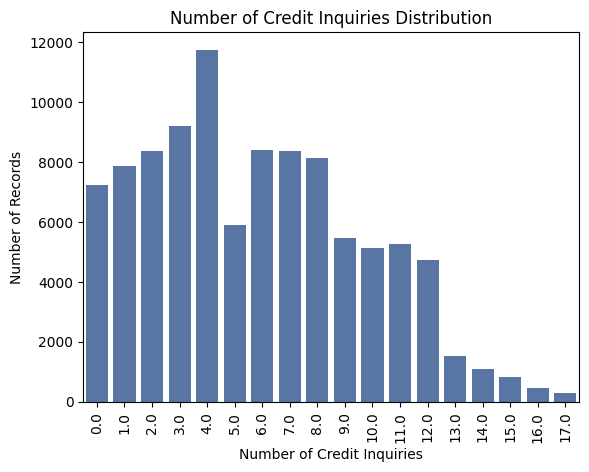

In [41]:
column_name = 'Num_Credit_Inquiries'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Credit Inquiries'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_countplot(df_train,column_name,user_friendly_name,rotation=90)

### Outstanding Debt

**Summary**

Details of Outstanding_Debt column

DataType:  object

There are no null values

Number of Unique Values:  13178

Distribution of column:

Outstanding_Debt
1360.45     24
460.46      23
1151.7      23
1109.03     23
467.7       16
            ..
245.46_      1
645.77_      1
174.79_      1
1181.13_     1
1013.53_     1
Name: count, Length: 13178, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Outstanding_Debt is changed to <class 'float'>

Existing Min, Max Values:
min       0.23
max    4998.07
Name: Outstanding_Debt, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min       0.23
max    4998.07
Name: Outstanding_Debt, dtype: float64

No. of Unique values after Cleaning: 12203

No. of Null values after Cleaning: 0

-----------------------------------------------------

Outstanding Debt Distribution


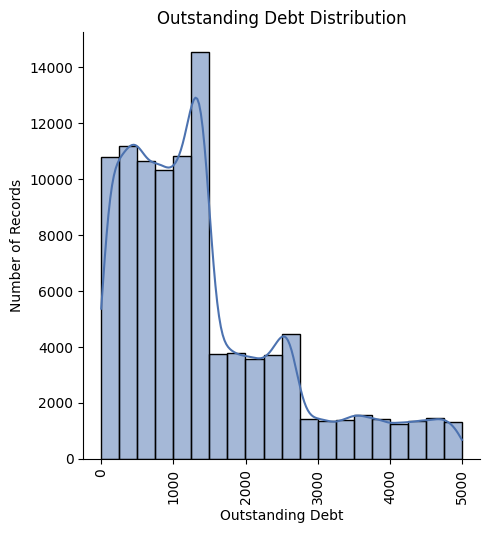

In [42]:
column_name = 'Outstanding_Debt'
group_by = 'Customer_ID'
user_friendly_name = 'Outstanding Debt'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype=float)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,rotation=90)

### Credit Utilization Ratio

**Summary**
1. No cleaning is required

Details of Credit_Utilization_Ratio column

DataType:  float64

There are no null values

Number of Unique Values:  100000

Distribution of column:

Credit_Utilization_Ratio
26.822620    1
28.327949    1
30.016576    1
25.478841    1
33.933755    1
            ..
30.687138    1
38.730069    1
30.017515    1
27.279794    1
34.192463    1
Name: count, Length: 100000, dtype: int64

-----------------------------------------------------

Credit Utilization Ratio Distribution


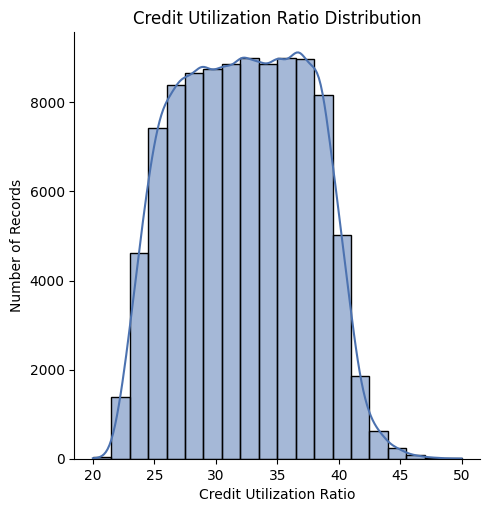

In [43]:
column_name = 'Credit_Utilization_Ratio'
group_by = 'Customer_ID'
user_friendly_name = 'Credit Utilization Ratio'

#Get Details
get_column_details(df_train,column_name)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name)

### Credit History Age

**Summary**


In [44]:
df_train['Credit_History_Age'].value_counts()

Credit_History_Age
15 Years and 11 Months    446
19 Years and 4 Months     445
19 Years and 5 Months     444
17 Years and 11 Months    443
19 Years and 3 Months     441
                         ... 
0 Years and 3 Months       20
0 Years and 2 Months       15
33 Years and 7 Months      14
33 Years and 8 Months      12
0 Years and 1 Months        2
Name: count, Length: 404, dtype: int64

In [45]:
def Month_Converter(val):
    if pd.notnull(val):
        years = int(val.split(' ')[0])
        month = int(val.split(' ')[3])
        return (years*12)+month
    else:
        return val
    
df_train['Credit_History_Age'] = df_train['Credit_History_Age'].apply(lambda x: Month_Converter(x)).astype(float)

Details of Credit_History_Age column

DataType:  float64

There are  9030  null values

Number of Unique Values:  404

Distribution of column:

Credit_History_Age
191.0    446
232.0    445
233.0    444
215.0    443
231.0    441
        ... 
3.0       20
2.0       15
403.0     14
404.0     12
1.0        2
Name: count, Length: 404, dtype: int64

-----------------------------------------------------

Cleaning steps 

Datatype of Credit_History_Age is changed to <class 'float'>

Existing Min, Max Values:
min      1.0
max    404.0
Name: Credit_History_Age, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min      1.0
max    397.0
Name: Credit_History_Age, dtype: float64

No. of Unique values after Cleaning: 397

No. of Null values after Cleaning: 0

-----------------------------------------------------

Credit History Age Distribution


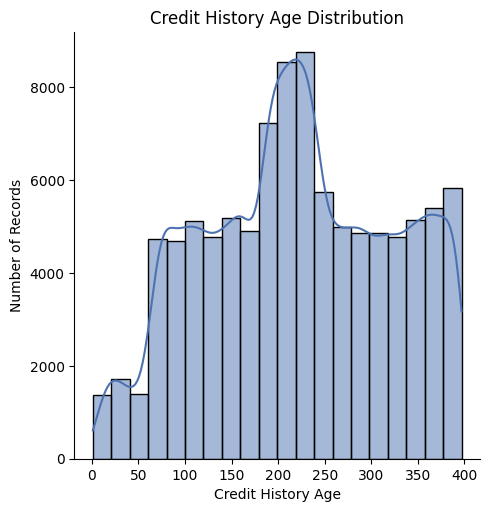

In [46]:
column_name = 'Credit_History_Age'
group_by = 'Customer_ID'
user_friendly_name = 'Credit History Age'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,datatype=float)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name)

### Total EMI per month

**Summary**

Details of Total_EMI_per_month column

DataType:  float64

There are no null values

Number of Unique Values:  14950

Distribution of column:

Total_EMI_per_month
0.000000        10613
49.574949           8
73.533361           8
22.960835           8
38.661127           8
                ...  
36408.000000        1
23760.000000        1
24612.000000        1
24325.000000        1
58638.000000        1
Name: count, Length: 14950, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min        0.0
max    82331.0
Name: Total_EMI_per_month, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min       0.000000
max    1779.103254
Name: Total_EMI_per_month, dtype: float64

No. of Unique values after Cleaning: 11890

No. of Null values after Cleaning: 0

-----------------------------------------------------

Total EMI per month Distribution


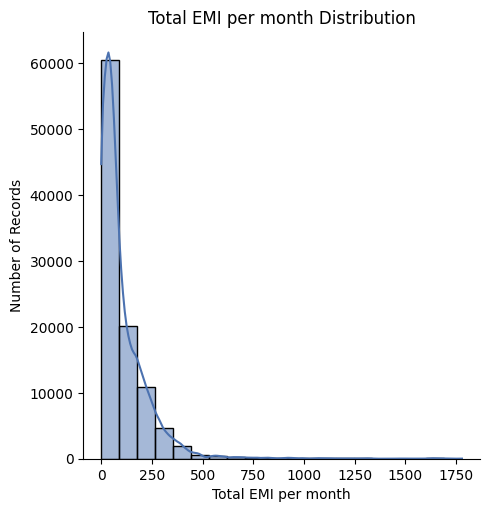

In [47]:
column_name = 'Total_EMI_per_month'
group_by = 'Customer_ID'
user_friendly_name = 'Total EMI per month'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name)

### Amount Invested Monthly

**Summary**

Details of Amount_invested_monthly column

DataType:  object

There are  4479  null values

Number of Unique Values:  91049

Distribution of column:

Amount_invested_monthly
__10000__             4305
0.0                    169
80.41529543900253        1
36.66235139442514        1
89.7384893604547         1
                      ... 
36.541908593249026       1
93.45116318631192        1
140.80972223052834       1
38.73937670100975        1
167.1638651610451        1
Name: count, Length: 91049, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Amount_invested_monthly is changed to <class 'float'>

Existing Min, Max Values:
min        0.0
max    10000.0
Name: Amount_invested_monthly, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min        0.0
max    10000.0
Name: Amount_invested_monthly, dtype: float64

No. of Unique values after Cleaning: 91049

No. of Null values after Cleaning: 0

-----------------------------------------------------

Amount invested monthly Distribution


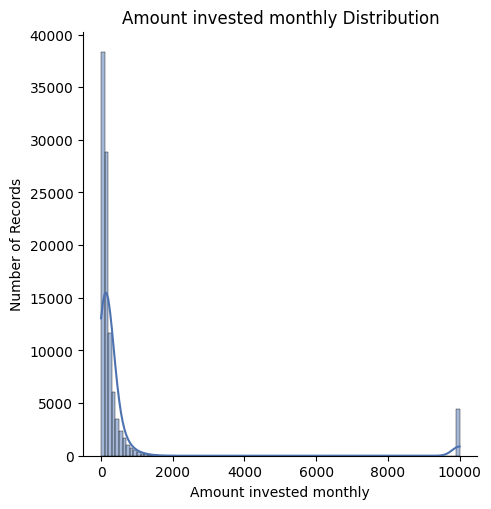

In [48]:
column_name = 'Amount_invested_monthly'
group_by = 'Customer_ID'
user_friendly_name = 'Amount invested monthly'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,datatype=float,strip='_')

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=100)

### Monthly Balance

**Summary**

Details of Monthly_Balance column

DataType:  object

There are  1200  null values

Number of Unique Values:  98792

Distribution of column:

Monthly_Balance
__-333333333333333333333333333__    9
312.49408867943663                  1
415.32532309844316                  1
252.08489793906085                  1
254.9709216273975                   1
                                   ..
366.2890379762706                   1
151.1882696261166                   1
306.75027851710234                  1
278.8720257394474                   1
393.6736955618808                   1
Name: count, Length: 98792, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value __-333333333333333333333333333__ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Monthly_Balance is changed to <class 'float'>

Existing Min, Max Values:
min       0.007760
max    1602.040519
Name: Monthly_Balance, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min       0.007760
max    1183.930696
Name: Monthly_Balance, dtype: float64

No. of Unique values after Cleaning: 96427

No. of Null values after Cleaning: 0

-----------------------------------------------------

Monthly Balance Distribution


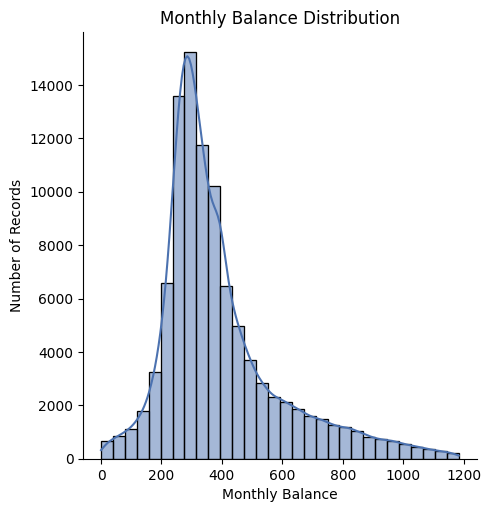

In [49]:
column_name = 'Monthly_Balance'
group_by = 'Customer_ID'
user_friendly_name = 'Monthly Balance'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
df_train[column_name].replace('',np.nan)
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype=float,replace_value='__-333333333333333333333333333__')

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=30)

### Number of Loan

**Summary**

Details of Num_of_Loan column

DataType:  object

There are no null values

Number of Unique Values:  434

Distribution of column:

Num_of_Loan
3        14386
2        14250
4        14016
0        10380
1        10083
         ...  
1320_        1
103          1
1444         1
392          1
966          1
Name: count, Length: 434, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Num_of_Loan is changed to <class 'float'>

Existing Min, Max Values:
min    -100.0
max    1496.0
Name: Num_of_Loan, dtype: float64


C:\Users\nagan\AppData\Local\Temp\ipykernel_4308\3591255760.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  x, y = df_dropped.apply(lambda x: stats.mode(x)).apply([min, max])



After Cleaning Min, Max Values:
min    0.0
max    9.0
Name: Num_of_Loan, dtype: float64

No. of Unique values after Cleaning: 10

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Loan Distribution


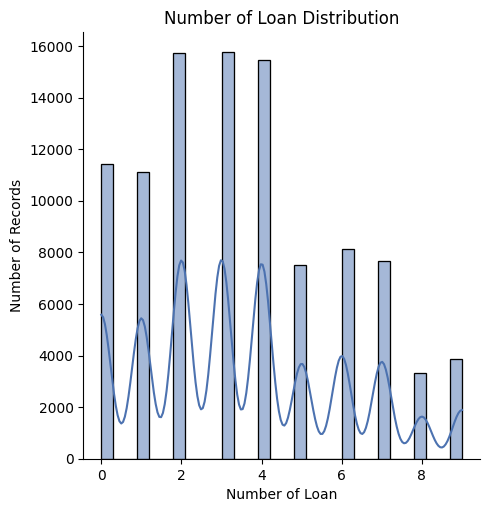

In [50]:
column_name = 'Num_of_Loan'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Loan'

#Get Details
get_column_details(df_train,column_name)

#Cleaning
clean_numerical_field(df_train,group_by,column_name,strip='_',datatype=float)

#Plot Graph
plot_displot(df_train,column_name,user_friendly_name,bins=30)

In [51]:
#Check if null values are present
df_train.isna().sum()

ID                          0
Customer_ID                 0
Month                       0
Name                        0
Age                         0
SSN                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Type_of_Loan                0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64

## <span style="color:#FA8072"> 5. Data Transformation </span> <a class="anchor" id="data_transformation"></a>

In [52]:
#Drop columns
print("Size of Dataset before dropping columns : ",df_train.shape)
drop_columns = ['ID','Customer_ID','Name','SSN']
df_train.drop(drop_columns,axis=1,inplace=True)
print("Size of Dataset after dropping columns : ",df_train.shape)

Size of Dataset before dropping columns :  (100000, 28)
Size of Dataset after dropping columns :  (100000, 24)


In [53]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['Occupation','Type_of_Loan','Credit_Mix','Payment_of_Min_Amount','Payment_Behaviour','Credit_Score']
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Loop through each column and apply label encoding
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])


In [54]:
df_train.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,1,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4.0,128,...,1,809.98,26.822620,265.0,1,49.574949,80.415295,2,312.494089,0
1,2,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4.0,128,...,1,809.98,31.944960,265.0,1,49.574949,118.280222,3,284.629162,0
2,3,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4.0,128,...,1,809.98,28.609352,267.0,1,49.574949,81.699521,4,331.209863,0
3,4,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4.0,128,...,1,809.98,31.377862,268.0,1,49.574949,199.458074,5,223.451310,0
4,5,23.0,12,19114.12,1824.843333,3.0,4.0,3.0,4.0,128,...,1,809.98,24.797347,269.0,1,49.574949,41.420153,1,341.489231,0


In [55]:
#Spli Input & Output Data
X = df_train.drop('Credit_Score',axis=1)
y = df_train['Credit_Score']
print(X.shape)
print(y.shape)

(100000, 23)
(100000,)


In [56]:
#Normalize Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## <span style="color:#FA8072"> 6. Model Building </span> <a class="anchor" id="model_building"></a>

### Approach 1

In [57]:
#Split Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 23)
(20000, 23)
(80000,)
(20000,)


In [58]:
#Method to evaluate the performance of the model
def evaluate_model(y_test,y_pred):
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    
    print("\n---------------------------------------------\n")
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap of the confusion matrix using Seaborn
    sns.heatmap(cm, annot=True, cmap='Greens',fmt='.0f')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

In [59]:
# List of classifiers to test
classifiers = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gaussion NB',GaussianNB()),
    ('XGB',xgb.XGBClassifier())
]

# Iterate over each classifier and evaluate performance
for clf_name, clf in classifiers:
    # Perform cross-validation
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    
    # Calculate average performance metrics
    avg_accuracy = scores.mean()
    avg_precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision_macro').mean()
    avg_recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall_macro').mean()
    
    # Print the performance metrics
    print(f'Classifier: {clf_name}')
    print(f'Average Accuracy: {avg_accuracy:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print('-----------------------')

Classifier: Decision Tree
Average Accuracy: 0.7220
Average Precision: 0.7055
Average Recall: 0.7052
-----------------------
Classifier: Random Forest
Average Accuracy: 0.8157
Average Precision: 0.8053
Average Recall: 0.8100
-----------------------
Classifier: KNN
Average Accuracy: 0.7030
Average Precision: 0.6757
Average Recall: 0.6851
-----------------------
Classifier: Gaussion NB
Average Accuracy: 0.6394
Average Precision: 0.6328
Average Recall: 0.6882
-----------------------
Classifier: XGB
Average Accuracy: 0.7742
Average Precision: 0.7590
Average Recall: 0.7639
-----------------------


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3566
           1       0.81      0.85      0.83      5799
           2       0.86      0.82      0.84     10635

    accuracy                           0.83     20000
   macro avg       0.82      0.83      0.82     20000
weighted avg       0.83      0.83      0.83     20000


---------------------------------------------



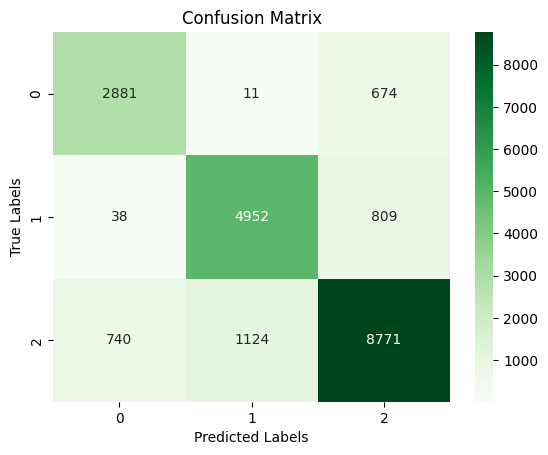

In [60]:
# Creating the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
evaluate_model(y_test, y_pred)

### Approach 2

In [62]:
#Handle Imbalance Data
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

y_sm.value_counts()

Credit_Score
0    53174
2    53174
1    53174
Name: count, dtype: int64

In [63]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(127617, 23)
(31905, 23)
(127617,)
(31905,)


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     10635
           1       0.87      0.91      0.89     10635
           2       0.89      0.79      0.84     10635

    accuracy                           0.89     31905
   macro avg       0.89      0.89      0.88     31905
weighted avg       0.89      0.89      0.88     31905


---------------------------------------------



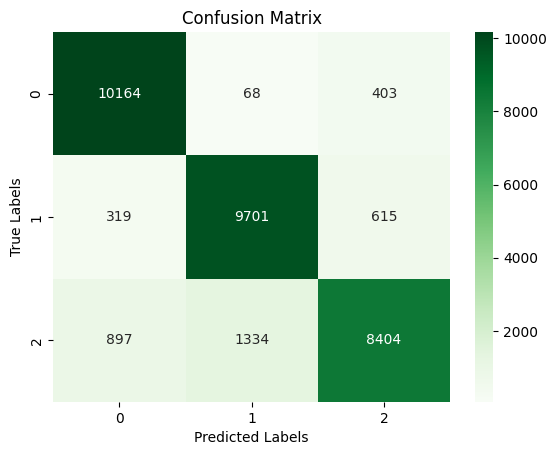

In [64]:
# Creating the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
evaluate_model(y_test, y_pred)